In [88]:
import imageio
import imgaug as ia
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
%matplotlib inline
import os 
import xml.etree.cElementTree as ET
import pandas as pd
import numpy as np
from tqdm import tqdm
import PIL

In [97]:
os.makedirs('./augmented_images')

In [83]:
files = os.listdir('./images/colectedimages')

In [84]:
files = [file[:-4] for file in files]

In [85]:
len(files)

228

In [86]:
files = set(files)
files = list(files)
print(len(files))

114


In [87]:
seq = iaa.Sequential([
    iaa.Fliplr(0.5), # horizontal flips
    iaa.Crop(percent=(0, 0.1)), # random crops
    # Small gaussian blur with random sigma between 0 and 0.5.
    # But we only blur about 50% of all images.
    iaa.Sometimes(
        0.5,
        iaa.GaussianBlur(sigma=(0, 0.5))
    ),
    # Strengthen or weaken the contrast in each image.
    iaa.LinearContrast((0.75, 1.5)),
    # Add gaussian noise.
    # For 50% of all images, we sample the noise once per pixel.
    # For the other 50% of all images, we sample the noise per pixel AND
    # channel. This can change the color (not only brightness) of the
    # pixels.
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
    # Make some images brighter and some darker.
    # In 20% of all cases, we sample the multiplier once per channel,
    # which can end up changing the color of the images.
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    # Apply affine transformations to each image.
    # Scale/zoom them, translate/move them, rotate them and shear them.
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    )
], random_order=True)

In [98]:
for file in tqdm(files):
    tree = ET.ElementTree(file='./images_new/' + file + '.xml')
    root = tree.getroot()
    filename_xml = tree.find('filename')
    xmin = tree.find('object').find('bndbox').find('xmin')
    ymin = tree.find('object').find('bndbox').find('ymin')
    xmax = tree.find('object').find('bndbox').find('xmax')
    ymax = tree.find('object').find('bndbox').find('ymax')
    height = tree.find('size').find('height')
    width = tree.find('size').find('width')
    bbs = BoundingBoxesOnImage([
        BoundingBox(x1=int(xmax.text), x2=int(xmin.text), y1=int(ymax.text), y2=int(ymin.text))
    ], shape=(int(height.text), int(width.text)))
        
    image = PIL.Image.open('./images_new/' + file + '.jpg')
    images_array = [np.array(image) for _ in range(16)]
    bbs_array = [bbs for _ in range(16)]
    #image_array = np.array(image)
    #image_aug, bbs_aug = seq(image=image_array, bounding_boxes = bbs)
    images_aug, bbss_aug = seq(images=images_array, bounding_boxes = bbs_array)
    
    for i, (image_aug, bb) in enumerate(zip(images_aug, bbss_aug)):
        filename = file + '-' + str(i)
        
        img_filename = filename + '.jpg'
        annotation_filename = filename + '.xml'
        
        im = PIL.Image.fromarray(image_aug)
        
        xmin.text = str(bb.bounding_boxes[0].x1_int)
        xmax.text = str(bb.bounding_boxes[0].x2_int)
        ymin.text = str(bb.bounding_boxes[0].y1_int)
        ymax.text = str(bb.bounding_boxes[0].y2_int)
        filename_xml.text = img_filename
        
        im.save('./augmented_images_new_1/' + img_filename)
        tree.write('./augmented_images_new_1/' + annotation_filename)

100%|██████████| 114/114 [03:29<00:00,  1.84s/it]


C:\Users\Risto\.conda\envs\newEnv\lib\site-packages\imgaug\imgaug.py:2120: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  fig.canvas.set_window_title("imgaug.imshow(%s)" % (image.shape,))


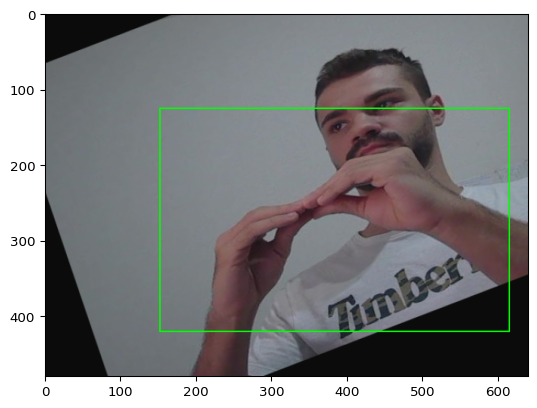

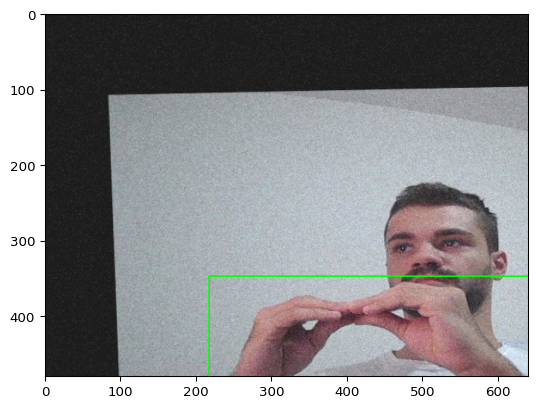

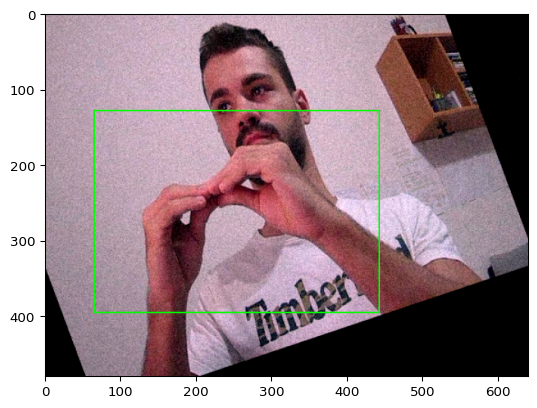

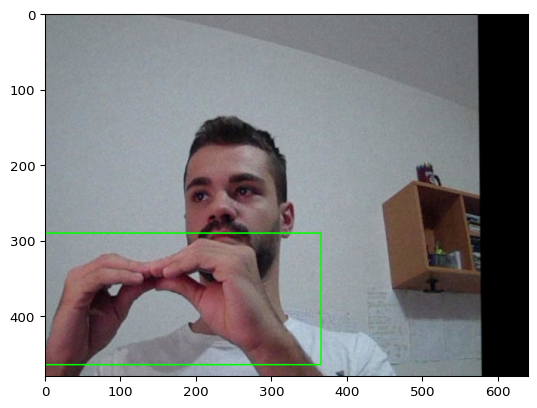

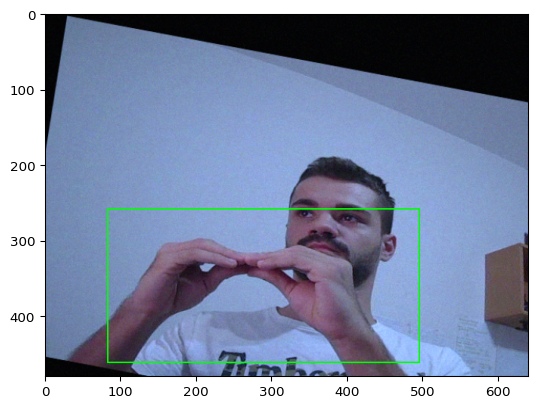

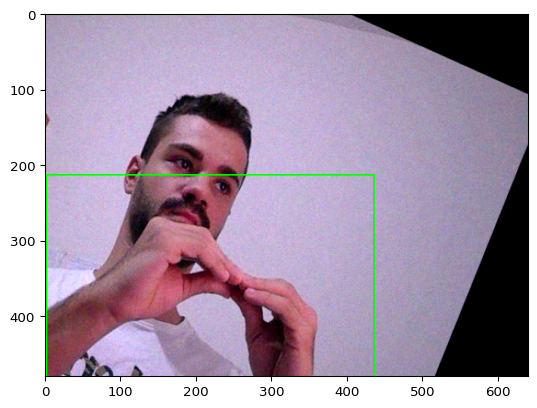

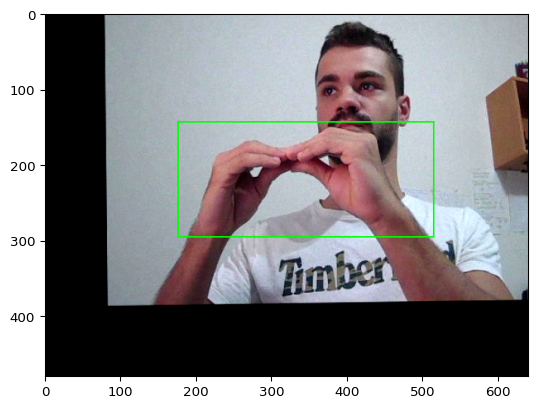

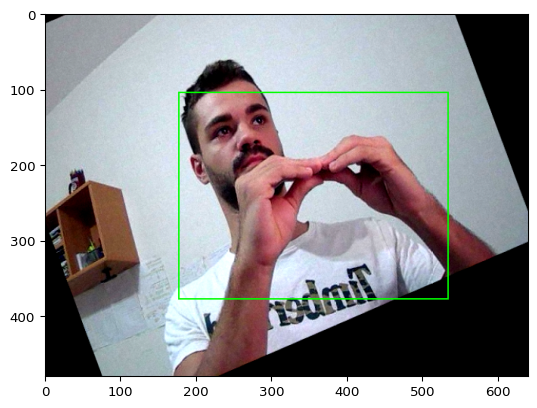

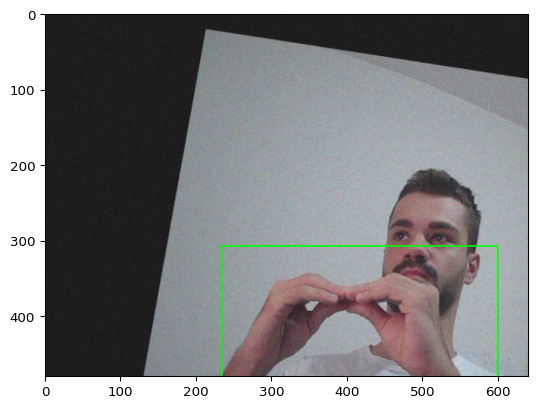

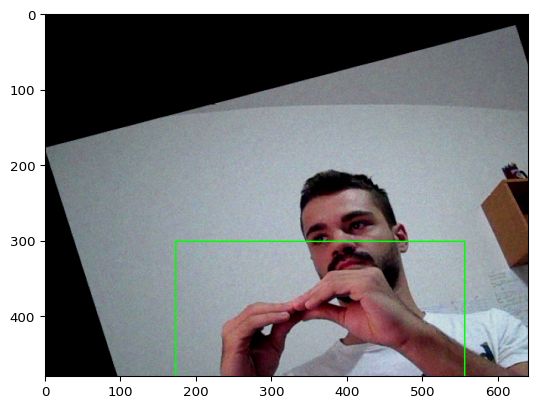

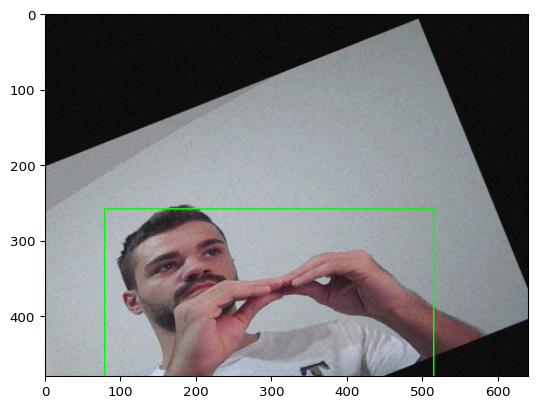

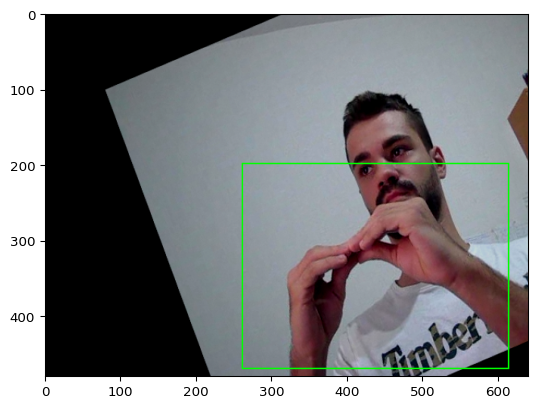

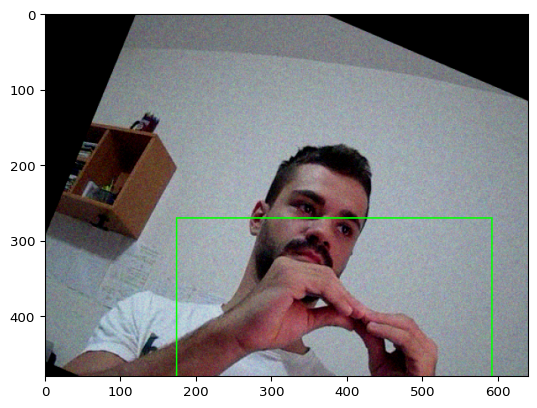

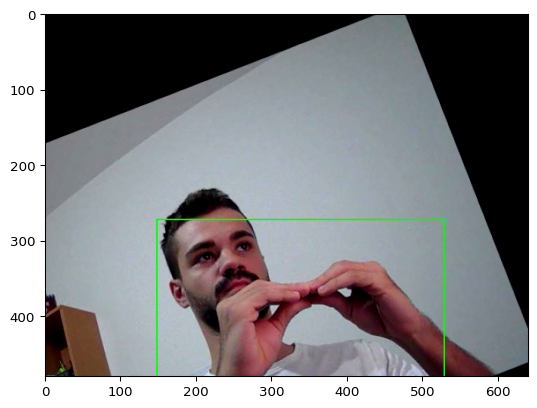

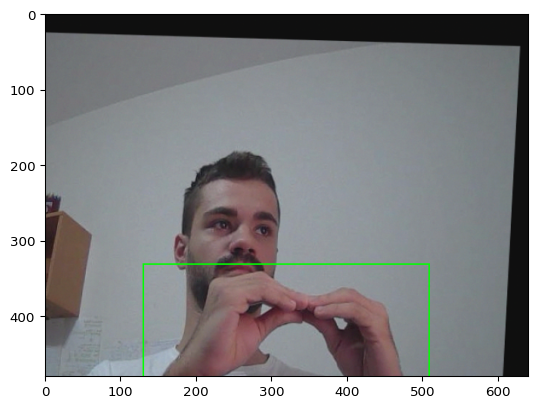

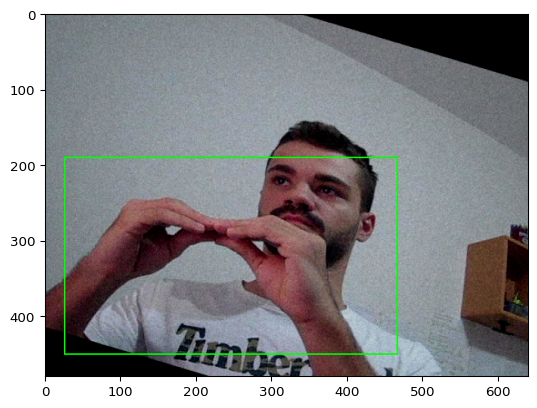

In [99]:
for image, bbs in zip(images_aug, bbss_aug):
    ia.imshow(bbs.draw_on_image(image, size=2))